### Comparing Aggregate Models for Regression

This try-it focuses on utilizing ensemble models in a regression setting.  Much like you have used individual classification estimators to form an ensemble of estimators -- here your goal is to explore ensembles for regression models.  As with your earlier assignment, you will use scikitlearn to carry out the ensembles using the `VotingRegressor`.   


#### Dataset and Task

Below, a dataset containing census information on individuals and their hourly wage is loaded using the `fetch_openml` function.  OpenML is another repository for datasets [here](https://www.openml.org/).  Your task is to use ensemble methods to explore predicting the `wage` column of the data.  Your ensemble should at the very least consider the following models:

- `LinearRegression` -- perhaps you even want the `TransformedTargetRegressor` here.
- `KNeighborsRegressor`
- `DecisionTreeRegressor`
- `Ridge`
- `SVR`

Tune the `VotingRegressor` to try to optimize the prediction performance and determine if the wisdom of the crowd performed better in this setting than any of the individual models themselves.  Report back on your findings and discuss the interpretability of your findings.  Is there a way to determine what features mattered in predicting wages?

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

# Load dataset
survey = fetch_openml(data_id=534, as_frame=True).frame



In [23]:
# Change feature names to lowercase
survey.columns = survey.columns.str.lower()

# Check for missing values
print(survey.isnull().sum())

# Drop rows with missing values
survey.dropna(inplace=True)

# Separate features and target variable
X = survey.drop(columns=['wage'])
y = survey['wage']

# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse
    
# Define individual regressors
linear_reg = LinearRegression()
knn_reg = KNeighborsRegressor()
tree_reg = DecisionTreeRegressor(random_state=42)
ridge_reg = Ridge()
svr_reg = SVR()

# Create pipelines for each regressor
pipelines = {
    'linear': Pipeline([('scaler', StandardScaler()), ('regressor', linear_reg)]),
    'knn': Pipeline([('scaler', StandardScaler()), ('regressor', knn_reg)]),
    'tree': Pipeline([('regressor', tree_reg)]),
    'ridge': Pipeline([('scaler', StandardScaler()), ('regressor', ridge_reg)]),
    'svr': Pipeline([('scaler', StandardScaler()), ('regressor', svr_reg)])
}

education     0
south         0
sex           0
experience    0
union         0
wage          0
age           0
race          0
occupation    0
sector        0
marr          0
dtype: int64


In [24]:
# Define the Voting Regressor
voting_reg = VotingRegressor(estimators=[
    ('linear', pipelines['linear']),
    ('knn', pipelines['knn']),
    ('tree', pipelines['tree']),
    ('ridge', pipelines['ridge']),
    ('svr', pipelines['svr'])
])

# Evaluate individual models without grid search
results_before_gs = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    mse = evaluate_model(pipeline, X_test, y_test)
    results_before_gs[name] = mse

# Evaluate Voting Regressor without grid search
voting_reg.fit(X_train, y_train)
voting_mse_before_gs = evaluate_model(voting_reg, X_test, y_test)
results_before_gs['voting'] = voting_mse_before_gs

# Print results before grid search
print("Results Before Grid Search:")
for name, mse in results_before_gs.items():
    print(f'{name}: MSE = {mse}')





Results Before Grid Search:
linear: MSE = 19.5025973241124
knn: MSE = 22.875903850467285
tree: MSE = 59.54706869158879
ridge: MSE = 19.49588844744507
svr: MSE = 21.709551807582425
voting: MSE = 21.537930170531713


In [25]:
# Define parameter grids for Grid Search
param_grids = {
    'linear': {},
    'knn': {'regressor__n_neighbors': [3, 5, 7, 9, 11]},
    'tree': {'regressor__max_depth': [None, 3, 5, 7, 10]},
    'ridge': {'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]},
    'svr': {'regressor__C': [0.1, 1.0, 10.0, 100.0], 'regressor__gamma': ['scale', 'auto']}
}

# Perform Grid Search and evaluate models
results_after_gs = {}
best_pipelines = {}

for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    best_pipeline = grid_search.best_estimator_
    best_pipelines[name] = best_pipeline
    mse = evaluate_model(best_pipeline, X_test, y_test)
    results_after_gs[name] = mse

# Define the optimized Voting Regressor
optimized_voting_reg = VotingRegressor(estimators=[
    ('linear', best_pipelines['linear']),
    ('knn', best_pipelines['knn']),
    ('tree', best_pipelines['tree']),
    ('ridge', best_pipelines['ridge']),
    ('svr', best_pipelines['svr'])
])

# Fit the optimized Voting Regressor
optimized_voting_reg.fit(X_train, y_train)
voting_mse_after_gs = evaluate_model(optimized_voting_reg, X_test, y_test)
results_after_gs['voting'] = voting_mse_after_gs

# Print results after grid search
print("\nResults After Grid Search:")
for name, mse in results_after_gs.items():
    print(f'{name}: MSE = {mse}')




Results After Grid Search:
linear: MSE = 19.5025973241124
knn: MSE = 22.091528377230247
tree: MSE = 22.469790483538922
ridge: MSE = 20.342923577644196
svr: MSE = 21.709551807582425
voting: MSE = 20.123528129248974


In [26]:
# Feature importance from Decision Tree
tree_reg.fit(X_train, y_train)
importances_tree = tree_reg.feature_importances_
feature_importance_tree_df = pd.DataFrame({'feature': X_train.columns, 'importance': importances_tree})
feature_importance_tree_df = feature_importance_tree_df.sort_values(by='importance', ascending=False)
print("\nFeature Importance from Decision Tree:")
print(feature_importance_tree_df)

# Coefficients from Linear regression
linear_reg.fit(X_train, y_train)
coefficients_linear = linear_reg.coef_
coefficients_linear_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coefficients_linear})
coefficients_linear_df = coefficients_linear_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Linear Regression:")
print(coefficients_linear_df)

# Coefficients from Ridge regression
ridge_reg.fit(X_train, y_train)
coefficients_ridge = ridge_reg.coef_
coefficients_ridge_df = pd.DataFrame({'feature': X_train.columns, 'coefficient': coefficients_ridge})
coefficients_ridge_df = coefficients_ridge_df.sort_values(by='coefficient', ascending=False)
print("\nCoefficients from Ridge Regression:")
print(coefficients_ridge_df)

# Feature importance using permutation for KNN
result_knn = permutation_importance(best_pipelines['knn'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_knn = pd.DataFrame({'feature': X_test.columns, 'importance': result_knn.importances_mean})
perm_importances_knn = perm_importances_knn.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from KNN:")
print(perm_importances_knn)

# Feature importance using permutation for SVR
result_svr = permutation_importance(best_pipelines['svr'], X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
perm_importances_svr = pd.DataFrame({'feature': X_test.columns, 'importance': result_svr.importances_mean})
perm_importances_svr = perm_importances_svr.sort_values(by='importance', ascending=False)
print("\nPermutation Importance from SVR:")
print(perm_importances_svr)


Feature Importance from Decision Tree:
                    feature  importance
1                experience    0.288039
0                 education    0.197098
2                       age    0.163294
8     occupation_Management    0.048567
5          union_not_member    0.045611
12       occupation_Service    0.041825
4                  sex_male    0.041818
3                 south_yes    0.035883
13     sector_Manufacturing    0.027274
15           marr_Unmarried    0.023815
6                race_Other    0.020453
7                race_White    0.016237
10  occupation_Professional    0.015194
11         occupation_Sales    0.013781
14             sector_Other    0.011247
9          occupation_Other    0.009866

Coefficients from Linear Regression:
                    feature  coefficient
8     occupation_Management     3.082299
4                  sex_male     1.763136
10  occupation_Professional     1.710179
7                race_White     0.838962
0                 education     0.830

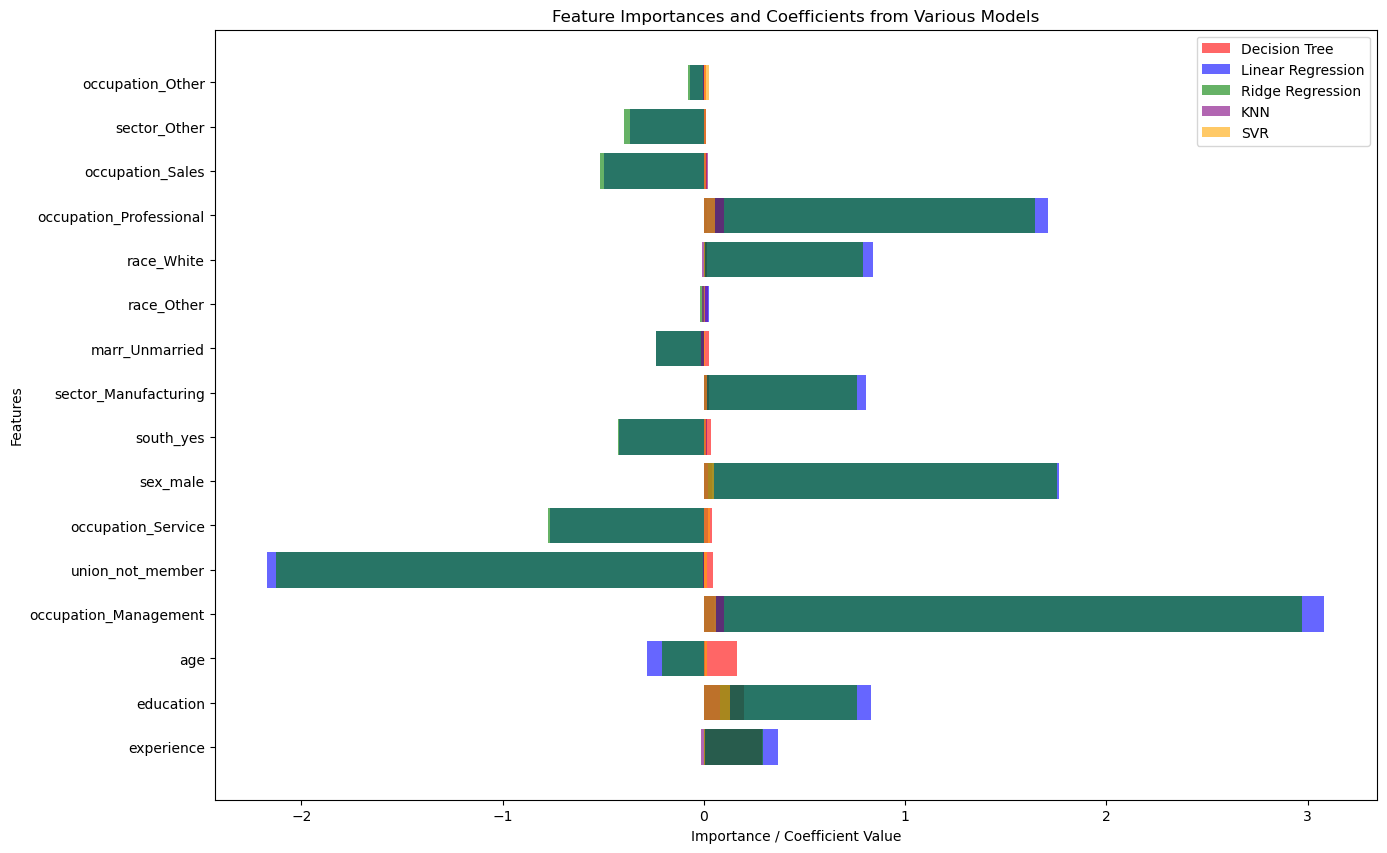

In [27]:
# Plotting the feature importances and coefficients
plt.figure(figsize=(15, 10))

# Plot Decision Tree feature importance
plt.barh(feature_importance_tree_df['feature'], feature_importance_tree_df['importance'], color='red', alpha=0.6, label='Decision Tree')

# Plot Linear Regression coefficients
plt.barh(coefficients_linear_df['feature'], coefficients_linear_df['coefficient'], color='blue', alpha=0.6, label='Linear Regression')

# Plot Ridge Regression coefficients
plt.barh(coefficients_ridge_df['feature'], coefficients_ridge_df['coefficient'], color='green', alpha=0.6, label='Ridge Regression')

# Plot KNN permutation importance
plt.barh(perm_importances_knn['feature'], perm_importances_knn['importance'], color='purple', alpha=0.6, label='KNN')

# Plot SVR permutation importance
plt.barh(perm_importances_svr['feature'], perm_importances_svr['importance'], color='orange', alpha=0.6, label='SVR')

plt.xlabel('Importance / Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importances and Coefficients from Various Models')
plt.legend()
plt.show()


Tuning Voting Regressor Weights...
Best Voting Regressor MSE: 20.09767369005373
Best Weights: [2, 1, 1, 2, 2]


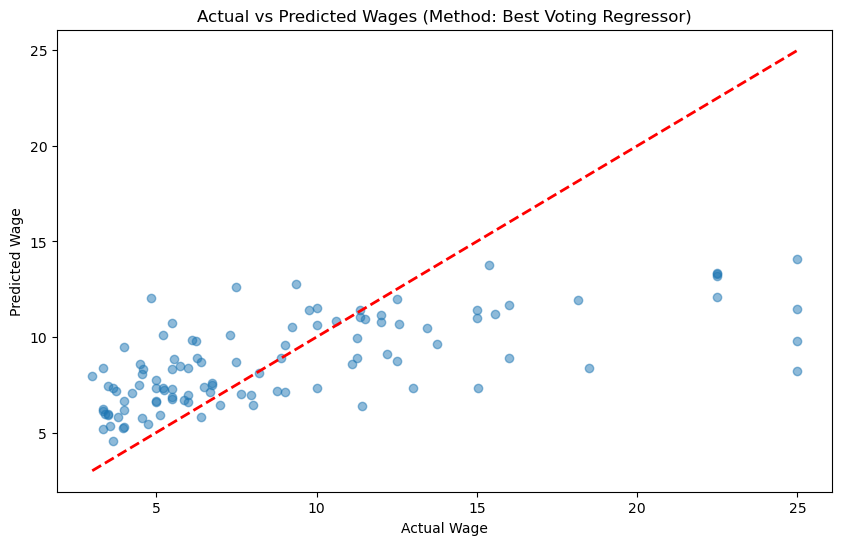

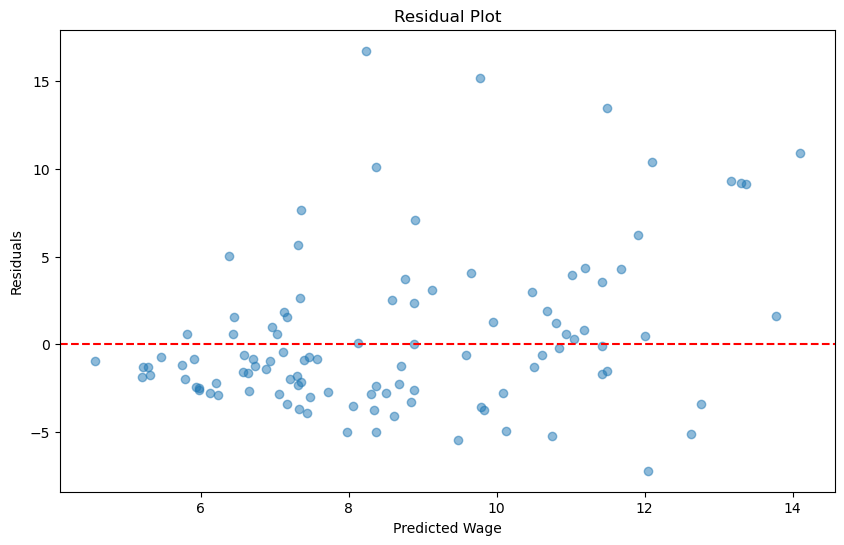

Analysis complete.


In [28]:
# Tuning Voting Regressor Weights
weight_options = [
    [1, 1, 1, 1, 1],       # Equal
    [2, 1, 1, 2, 2],       # Bias towards linear/ridge/svr
    [3, 1, 1, 3, 3],       # Strong bias
    [1, 0, 0, 1, 1],       # Exclude weak
    [1, 0.5, 0.5, 1, 1]    # Downweight weak
]

best_voting_mse = float('inf')
best_weights = None
best_voting_reg = None

print("\nTuning Voting Regressor Weights...")
for w in weight_options:
    voting_reg = VotingRegressor(estimators=[
        ('linear', best_pipelines['linear']),
        ('knn', best_pipelines['knn']),
        ('tree', best_pipelines['tree']),
        ('ridge', best_pipelines['ridge']),
        ('svr', best_pipelines['svr'])
    ], weights=w)
    voting_reg.fit(X_train, y_train)
    mse = evaluate_model(voting_reg, X_test, y_test)
    if mse < best_voting_mse:
        best_voting_mse = mse
        best_weights = w
        best_voting_reg = voting_reg
        
print(f"Best Voting Regressor MSE: {best_voting_mse}")
print(f"Best Weights: {best_weights}")

# Plots
import seaborn as sns

# Actual vs Predicted
y_pred_voting = best_voting_reg.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_voting, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.title('Actual vs Predicted Wages (Method: Best Voting Regressor)')
plt.show()

# Residuals
residuals = y_test - y_pred_voting
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_voting, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Wage')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

print("Analysis complete.")